# Анализ рейтингов бакалавриатов МИЭМ НИУ ВШЭ

## Сбор данных

Первым делом нужно получить данные. В нашем случае - запарсить сайт МИЭМ НИУ ВШЭ.
Устанавливаем selenium и webdriver-manager для работы с сайтами, которые используют JavaScript:

In [ ]:
pip install selenium webdriver-manager


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Импортируем необходимые библиотеки и их модули. А также устанавливаем настройки для Chrome, чтобы парсинг происходил быстрее:

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time

from selenium.webdriver.chrome.options import Options

chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--disable-images")
chrome_options.add_argument("--disable-css")
chrome_options.add_argument("--blink-settings=imagesEnabled=false")

from webdriver_manager.chrome import ChromeDriverManager
from webdriver_manager.core.os_manager import ChromeType

Скачиваем нужную версию драйвера Chromium и запускает браузер:

In [ ]:
service = Service(ChromeDriverManager(chrome_type=ChromeType.CHROMIUM).install())
browser = webdriver.Chrome(service=service, options=chrome_options)

Подгототавливаем датафрейм, в который сохраним результат:

In [ ]:
import pandas as pd
cols = ['Program', 'Study year', 'Semester', 'Course', 'Student ID', 'Position in Rating', 'Average Grade', 'Minimal Grade', 'Percentile', 'GPA']
df = pd.DataFrame(columns=cols)

Функция, которая обрабатывает рейтинг: получает ФИО, номер в рейтинге и т.д.

In [ ]:
def process_rating(browser, years, sem_num, OP, course, data):
    rating = WebDriverWait(browser, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'table-wrapper'))) #ждем пока страница загрузится

    FIO = rating.find_elements(By.CSS_SELECTOR, '.special-table__cell.special-table__cell--stud')
    position = rating.find_elements(By.CSS_SELECTOR, '.special-table__cell.special-table__cell--place:not([style*="display: none"])')
    mid_grade = rating.find_elements(By.CSS_SELECTOR, '.special-table__cell.special-table__cell--grade_mid')
    min_grade = rating.find_elements(By.CSS_SELECTOR, '.special-table__cell--grade_min')
    percentile = rating.find_elements(By.CSS_SELECTOR, '.special-table__cell--percentil')
    gpa = rating.find_elements(By.CSS_SELECTOR, '.special-table__cell--grade_gpa')

    for k in range(len(FIO)):
        data.append([OP, years, sem_num, course.text[0], FIO[k].text, position[k].text, mid_grade[k].text, min_grade[k].text, percentile[k].text, gpa[k].text])

Функция, которая обрабатывает каждую ссылку(каждую образовательную программу), использует предыдущую функцию и возвращает массив с данными:

In [ ]:
def process_link(browser, link):
    browser.get(link)
    time.sleep(0.2)

    OP = browser.title.replace('Образовательная программа «','').replace('» — Национальный исследовательский университет «Высшая школа экономики»','')

    search_button = browser.find_elements(By.TAG_NAME, 'button') #находим все кнопки на странице
    options = browser.find_elements(By.TAG_NAME, 'option') #ищем на странице все возможные опции

    ratings = []
    courses = []

    for option in options:  #оставляем только нужные нам опции
        if 'Текущий рейтинг 2' in option.text:
            ratings.append(option)
        elif 'курс' in option.text:
            courses.append(option)

    data = []
    for i in range(len(ratings)):
        ratings[i].click() #выбираем рейтинг

        rating_info = ratings[i].text.split()
        years = rating_info[2][:9] #берем из него курс и номер семестра
        sem_num = '1' if rating_info[-2][1] == '1' else '2'

        for j in range(4):
            courses[j].click() #выбираем курс
            search_button[2].click() #нажимаем "Показать", чтобы появился выбранный рейтинг

            try:
                process_rating(browser, years, sem_num, OP, courses[j], data)
                print(f'ОП {OP}, {years}, {sem_num} сем., {courses[j].text[0]} курс - успешно загружен')

            except Exception as e:
                print(f'ОП {OP}, {years}, {sem_num} сем., {courses[j].text[0]} курс - произошла ошибка {e}')
    return data

Запускаем процесс, добавляем всё в итоговый датафрейм:

In [ ]:
links = ['https://www.hse.ru/ba/isct/ratings', 'https://www.hse.ru/ba/am/ratings', 'https://www.hse.ru/ba/it/ratings', 'https://www.hse.ru/ba/is/ratings']

for link in links:
    data = process_link(browser, link)
    temp_df = pd.DataFrame(data, columns=cols)
    df = pd.concat([df, temp_df], axis = 0)

ОП Информатика и вычислительная техника, 2024/2025, 1 сем., 1 курс - успешно загружен
ОП Информатика и вычислительная техника, 2024/2025, 1 сем., 2 курс - успешно загружен
ОП Информатика и вычислительная техника, 2024/2025, 1 сем., 3 курс - успешно загружен
ОП Информатика и вычислительная техника, 2024/2025, 1 сем., 4 курс - успешно загружен
ОП Информатика и вычислительная техника, 2023/2024, 2 сем., 1 курс - успешно загружен
ОП Информатика и вычислительная техника, 2023/2024, 2 сем., 2 курс - успешно загружен
ОП Информатика и вычислительная техника, 2023/2024, 2 сем., 3 курс - успешно загружен
ОП Информатика и вычислительная техника, 2023/2024, 2 сем., 4 курс - успешно загружен
ОП Информатика и вычислительная техника, 2023/2024, 1 сем., 1 курс - успешно загружен
ОП Информатика и вычислительная техника, 2023/2024, 1 сем., 2 курс - успешно загружен
ОП Информатика и вычислительная техника, 2023/2024, 1 сем., 3 курс - успешно загружен
ОП Информатика и вычислительная техника, 2023/2024, 1 

Видим, что у ОП "Информационная безопасность" под конец получилось много ошибок. Это связано с тем, что программа появилась только в 2019 году, поэтому 1, 2, 3, 4 курсы появились не сразу.

В целях конфиденциальности заменим ФИО студентов на значения хэш-функции. Сейчас в df столько уникальных студентов:

In [ ]:
len(df['Student ID'].unique())

4603

Применяем хэш-функцию:

In [ ]:
df['Student ID'] = df['Student ID'].apply(lambda x: 'Студент ' + str(hash(x)%10_000_000))

Видим, что число студентов не изменилось:

In [ ]:
len(df['Student ID'].unique())

4603

В итоге получаем датафрейм со следующими столбцами:

*   ОП - образовательная программа
*   Study year - учебный год, к которому относится рейтинг
*   Semester - номер семестра(1 или 2)
*   Course - номер курса
*   Student ID - уникальное значение для каждого студента(используется вместо ФИО в целях конфиденциальности)
*   Position in Rating - позиция студента в рейтинге
*  	Average Grade - средняя оценка студента за семестр
*  	Minimal Grade - минимальная оценка за семестр
* 	Percentile - процент студентов, которые находятся над данным студентом в рейтинге
*   GPA - средневзвешенный балл(рассчитывается с учётом веса каждой дисциплины)



In [ ]:
df.sample(10)

,ОП,Study year,Semester,Course,Student ID,Position in Rating,Average Grade,Minimal Grade,Percentile,GPA
778,Информационная безопасность,2023/2024,2,3,Студент 9502493,41 - 43,7.27,5,32.79%,7.15
2276,Прикладная математика,2021/2022,1,1,Студент 5051542,95,7,5,64.83%,6.52
4439,Прикладная математика,2018/2019,2,1,Студент 1310321,31 - 33,8.45,6,23.08%,8.20
7235,Информатика и вычислительная техника,2018/2019,1,1,Студент 8079737,105 - 106,7.33,4,57.14%,7.79
4890,Информатика и вычислительная техника,2020/2021,2,4,Студент 2461607,121 - 122,6.25,3,92.31%,6.13
4922,Прикладная математика,2018/2019,1,2,Студент 9088833,23,7.71,6,16.79%,7.86
5559,Информатика и вычислительная техника,2019/2020,2,1,Студент 471919,52 - 53,8.22,6,30.36%,8.16
641,Информатика и вычислительная техника,2024/2025,1,4,Студент 8248629,21 - 22,8.14,7,14.93%,8.12
7611,Информатика и вычислительная техника,2018/2019,1,4,Студент 683007,20 - 32,9.5,9,12.75%,9.75
406,Информатика и вычислительная техника,2024/2025,1,2,Студент 9204314,114 - 118,6.88,5,52.07%,6.93


Сохраняем полученный датафрейм:

In [ ]:
df.to_csv('miem_ratings.csv', index=False, encoding='utf-8-sig')

## Подготовка данных

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/datasets/miem_ratings.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Сначала произведем незначительные изменения в датафрейме: заменим названия образовательных программ на их короткие версии:

In [ ]:
d = {
    'Информатика и вычислительная техника': 'ИВТ',
    'Прикладная математика': 'ПМ',
    'Инфокоммуникационные технологии и\xa0системы связи': 'ИТСС',
    'Информационная безопасность': 'ИБ'
}
df['Program'] = df['Program'].map(d)

А также изменим тип колонки Percentile:

In [ ]:
df['Percentile'] = df['Percentile'].str.replace('%','').astype('float64')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19501 entries, 0 to 19500
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Program             19501 non-null  object 
 1   Study year          19501 non-null  object 
 2   Semester            19501 non-null  int64  
 3   Course              19501 non-null  int64  
 4   Student ID          19501 non-null  object 
 5   Position in Rating  19501 non-null  object 
 6   Average Grade       19459 non-null  float64
 7   Minimal Grade       19410 non-null  float64
 8   Percentile          19501 non-null  float64
 9   GPA                 19501 non-null  float64
dtypes: float64(4), int64(2), object(4)
memory usage: 1.5+ MB


Теперь типы всех колонок нас устраивают.

Во время предварительного просмотра рейтингов было обнаружено множество ошибок. Например, для нескольких потоков был неправильно указан номер курса или человек с низким GPA(по нему строятся рейтинги) находился не на своем месте. Все такие ошибки необходимо найти и исправить, чтобы результаты анализа были корректными.

#### Неверный курс и слипшиеся рейтинги

На месте одного из рейтингов по ошибке появилось несколько студентов, которых надо удалить. А на их место сейчас вернем рейтинги, у которых неправильно стоит номер курса.

In [ ]:
condition = (df['Study year']=='2023/2024') & (df['Program'] == 'ПМ') & (df['Semester'] == 2)

df.drop(df[condition & (df['Course'] == 1)].index, inplace = True) #убрали этих студентов

condition = (df['Study year']=='2023/2024') & (df['Program'] == 'ПМ') & (df['Semester'] == 2)

Меняем номер курса:

In [ ]:
df.loc[condition & (df['Course'] == 2), 'Course'] = 1
df.loc[condition & (df['Course'] == 3), 'Course'] = 2

По ходу дела оказалось, что на сайте ВУЗа два рейтинга "слиплись" в один. Поэтому здесь просто поменять номер курса не получится, нужно будет повозиться и определить, кто действительно с 4 курса, а кому случайно поставили не тот курс.
Для этого берем студентов слипшегося рейтинга, а также рейтинги предыдущего семестра для этих двух потоков:

In [ ]:
two_in_one = df[condition & (df['Course'] == 4)]['Student ID'] #слипшийся рейтинг

prev_4_condition = (df['Study year']=='2023/2024') & (df['Program'] == 'ПМ') & (df['Semester'] == 1) & (df['Course'] == 4)
prev_3_condition = (df['Study year']=='2023/2024') & (df['Program'] == 'ПМ') & (df['Semester'] == 1) & (df['Course'] == 3)

prev_4_ID = df[prev_4_condition]['Student ID'] #предыдущий рейтинг для 4 курса
prev_3_ID = df[prev_3_condition]['Student ID'] #предыдущий рейтинг для 3 курса

Найдем студентов, которых нет в обоих рейтингах:

In [ ]:
for student in two_in_one:
  if (student not in prev_4_ID.values) and (student not in prev_3_ID.values):
    print(student)

Студент 179044
Студент 4921554
Студент 2806553


Видим, что Студент 179044	судя по всему учился на 4 курсе, а потом ушел в академический отпуск(ушел в 2022/2023 уч.году, вернулся в 2023/2024 уч.г). Менять значение курса не требуется

In [ ]:
df[(df['Student ID'] == 'Студент 179044') & (df['Course']>=3)]

,Program,Study year,Semester,Course,Student ID,Position in Rating,Average Grade,Minimal Grade,Percentile,GPA
8428,ПМ,2023/2024,2,4,Студент 179044,145,4.0,4.0,96.00,4.00
9141,ПМ,2022/2023,2,4,Студент 179044,71,6.2,4.0,85.37,7.21
9498,ПМ,2022/2023,1,4,Студент 179044,50 - 51,7.2,4.0,61.25,7.33
9793,ПМ,2021/2022,2,3,Студент 179044,52,6.1,3.0,64.56,6.32
10187,ПМ,2021/2022,1,3,Студент 179044,23 - 24,7.0,3.0,26.51,7.32


Студент 4921554 видимо также взял академический отпуск(видим крайне низкие баллы). Но ушел в академ. отпуск уже на 3 курсе, а не на 4, поэтому курс надо поменять.

In [ ]:
df[(df['Student ID'] == 'Студент 4921554') & (df['Course']>=3)]

,Program,Study year,Semester,Course,Student ID,Position in Rating,Average Grade,Minimal Grade,Percentile,GPA
8431,ПМ,2023/2024,2,4,Студент 4921554,148,1.00,4.0,98.00,1.08
9070,ПМ,2022/2023,2,3,Студент 4921554,80,1.67,0.0,98.75,1.56
9438,ПМ,2022/2023,1,3,Студент 4921554,74,4.71,3.0,86.90,4.80


Аналогично Студенту 179044, считаем, что Студент 2806553 взял академический отпуск на 4 курсе.

In [ ]:
df[(df['Student ID'] == 'Студент 2806553') & (df['Course']>=3)]

,Program,Study year,Semester,Course,Student ID,Position in Rating,Average Grade,Minimal Grade,Percentile,GPA
8432,ПМ,2023/2024,2,4,Студент 2806553,149 - 150,0.00,NaN,100.00,0.00
9098,ПМ,2022/2023,2,4,Студент 2806553,28,8.67,4.0,32.93,9.05
9520,ПМ,2022/2023,1,4,Студент 2806553,72,5.86,3.0,88.75,5.61
9820,ПМ,2021/2022,2,3,Студент 2806553,79,3.89,0.0,98.73,4.00
10242,ПМ,2021/2022,1,3,Студент 2806553,78,4.57,0.0,92.77,4.55
11602,ПМ,2019/2020,2,3,Студент 2806553,105,4.43,2.0,94.55,4.40
12056,ПМ,2019/2020,1,3,Студент 2806553,109,2.67,3.0,96.43,3.40


Меняем значения для студента 4921554 и всех студентов 3 курса, которые по ошибке попали в рейтинг 4 курса:

In [ ]:
df.loc[(df['Student ID'] == 'Студент 4921554') & condition, 'Course'] = 3
df.loc[condition & (df['Course'] == 4) & (df['Student ID'].isin(prev_3_ID.values)), 'Course'] = 3

Также необходимо подправить перцентиль:

In [ ]:
def correct_percentile(course): #функция корректировки перцентиля
  #берем определенный курс, сортируем их рейтинг по GPA и получаем Student ID
  students = df.loc[condition & (df['Course'] == course)].sort_values('GPA', ascending = False)['Student ID'].to_list()

  for i in range(len(students)): #меняем перцентиль
    df.loc[condition & (df['Course'] == course) & (df['Student ID'] == students[i]), 'Percentile'] = round(i/len(students)*100, 2)

correct_percentile(3)
correct_percentile(4)

Посмотрим, нет ли еще слипшихся рейтингов. То есть нужно искать резкое увеличение, а потом уменьшение количества людей в рейтинге на определенном курсе каждой программы:

In [ ]:
df.groupby(['Program', 'Study year', 'Semester', 'Course']).agg({'Student ID': 'count'})

Student ID
Program Study year Semester Course            
ИБ      2019/2020  1        1               57
                   2        1               52
        2020/2021  1        1               68
                            2               46
                   2        1               66
                            2               47
        2021/2022  1        1              182
                            2               62
                            3               44
                   2        1              164
                            2               58
                            3               44
        2022/2023  1        1              151
                            2              144
                            3               51
                            4               43
                   2        1              131
                            2              142
                            3               49
                            4               40
        2023/2024  1        1              142
                            2              117
                            3              139
                            4               48
                   2        1              125
                            2              105
                            3              122
                            4               45
        2024/2025  1        1              149
                            2              124
                            3              111
                            4              124
ИВТ     2018/2019  1        1              182
                            2              151
                            3              127
                            4              149
                   2        1              174
                            2              146
                            3              126
                            4                5
        2019/2020  1        1              175
                            2              160
                            3              139
                            4              123
                   2        1              168
                            2              153
                            3              136
                            4              119
        2020/2021  1        1              163
                            2              160
                            3              149
                            4              135
                   2        1              162
                            2              161
                            3              153
                            4              130
        2021/2022  1        1              171
                            2              152
                            3              155
                            4              151
                   2        1              140
                            2              145
                            3              148
                            4              141
        2022/2023  1        1              141
                            2              130
                            3              140
                            4              145
                   2        1              127
                            2              134
                            3              138
                            4              148
        2023/2024  1        1              278
                            2              115
                            3              123
                            4              132
                   2        1              223
                            2              107
                            3              123
                            4              132
        2024/2025  1        1              293
                            2              217
                            3              111
                            4            

Таких скачков обнаружено не было

#### Исправление неправильной последовательности GPA

Будем искать строки в рейтинге, которые находятся не на своем месте по GPA. То есть должны быть ниже или выше своего положения. Для этого добавим в датафрейм два столбца: с GPA в предыдущей строке рейтинга и в следующей:

In [ ]:
df['Prev GPA'] = df.groupby(['Program', 'Study year', 'Semester', 'Course'])['GPA'].shift(-1)
df['Foll GPA'] = df.groupby(['Program', 'Study year', 'Semester', 'Course'])['GPA'].shift(1)

К счастью, есть всего две такие строки. Они оказались даже из одного рейтинга:

In [ ]:
df[(df['Prev GPA'] < df['GPA'])&(df['Foll GPA']<df['GPA'])]

,Program,Study year,Semester,Course,Student ID,Position in Rating,Average Grade,Minimal Grade,Percentile,GPA,Prev GPA,Foll GPA
16268,ИТСС,2018/2019,1,1,Студент 4022684,null - 1,6.8,5.0,0.0,6.11,5.42,1.61


In [ ]:
df[(df['Prev GPA'] > df['GPA'])&(df['Foll GPA']>df['GPA'])]

,Program,Study year,Semester,Course,Student ID,Position in Rating,Average Grade,Minimal Grade,Percentile,GPA,Prev GPA,Foll GPA
16267,ИТСС,2018/2019,1,1,Студент 2343951,72,2.67,7.0,98.61,1.61,6.11,3.87


Такое произошло из-за того, что в рейтинге появились две ошибочные строки(перцинтили 0, 50 и отсутствует место в рейтинге). Удалим их:

In [ ]:
condition = (df['Program'] == 'ИТСС') & (df['Study year'] == '2018/2019') & (df['Semester'] == 1) & (df['Course'] == 1)
df[condition & (df['GPA']<6.5)]

,Program,Study year,Semester,Course,Student ID,Position in Rating,Average Grade,Minimal Grade,Percentile,GPA,Prev GPA,Foll GPA
16258,ИТСС,2018/2019,1,1,Студент 4528837,63,6.57,4.0,86.11,6.48,6.43,6.57
16259,ИТСС,2018/2019,1,1,Студент 386265,64,6.43,3.0,87.50,6.43,6.04,6.48
16260,ИТСС,2018/2019,1,1,Студент 1738420,65 - 66,6.14,1.0,88.89,6.04,6.04,6.43
16261,ИТСС,2018/2019,1,1,Студент 8326521,65 - 66,6.71,1.0,88.89,6.04,5.91,6.04
16262,ИТСС,2018/2019,1,1,Студент 4471800,67,6.71,2.0,91.67,5.91,5.74,6.04
16263,ИТСС,2018/2019,1,1,Студент 3682794,68,6.14,2.0,93.06,5.74,5.30,5.91
16264,ИТСС,2018/2019,1,1,Студент 6948133,69,5.71,2.0,94.44,5.30,4.83,5.74
16265,ИТСС,2018/2019,1,1,Студент 9121997,70,5.71,3.0,95.83,4.83,3.87,5.30
16266,ИТСС,2018/2019,1,1,Студент 8777081,71,4.71,3.0,97.22,3.87,1.61,4.83
16267,ИТСС,2018/2019,1,1,Студент 2343951,72,2.67,7.0,98.61,1.61,6.11,3.87


In [ ]:
df.drop(df[condition & (df['Position in Rating'] == 'null - 1')].index, inplace = True)
df.drop(['Prev GPA', 'Foll GPA'], axis = 1, inplace = True)

#### Работа с пропусками

In [ ]:
df.isnull().sum()

,0
Program,0
Study year,0
Semester,0
Course,0
Student ID,0
Position in Rating,0
Average Grade,42
Minimal Grade,91
Percentile,0
GPA,0


Посмотрим на студентов, у которых пустые поля Minimal Grade или Average Grade. Оказывается у таких студентов перцентиль 100%(у двух студентов он перестал быть таким после того, как мы внесли корректировки, но это не отменяет факт того, что до этого он был 100). В обычной ситуации такого не может быть, потому что перцентиль для конкретного студента = кол-во людей выше этого студента в рейтинге/общее число студентов в рейтинге * 100. Перцентиль 100 означает, что студенты уже вне рейтинга, поэтому пересчитывать перцентиль для всех студентов в рейтинге после удаления строк с пустыми значениями не требуется.

In [ ]:
df[(df['Minimal Grade'].isnull()) | (df['Minimal Grade'].isnull())]['Percentile'].unique() #у таких студентов перцентиль 100; и два значения, которые посчитали мы

array([100.  ,  96.97,  98.48])

Смело удаляем студентов с пустыми Minimal Grade или Average Grade:

In [ ]:
df.drop(df[((df['Minimal Grade'].isnull()) | (df['Average Grade'].isnull()))].index, inplace = True, axis = 0)

И посмотрим, нет ли еще студентов с 100% перцентилем. Есть:

In [ ]:
len(df[df['Percentile'] == 100])

43

Их тоже удалим:

In [ ]:
df.drop(df[df['Percentile'] == 100].index, axis = 0, inplace = True)

#### Чистка отсутствующих рейтингов

В ходе анализа было обнаружено, что в 2018/2019 уч. г. во 2 семестре для 4 курса не было опубликовано рейтингов на всех ОП. Всего в данных нашлось 8 студентов, которые по ошибке появились на месте этих рейтингов. Их необходимо удалить:

In [ ]:
df.drop(df[(df['Study year'] == '2018/2019') & (df['Course']==4) & (df['Semester'] == 2)].index, axis = 0, inplace = True)

#### Удаление дубликатов

Также было обнаружено, что иногда в рейтингах дублировались строки. Удалим дубликаты:

In [ ]:
df = df.reset_index() #так как до этого уже удаляли строки, то нужно переиндексировать df
df.drop('index', axis = 1, inplace = True)

In [ ]:
for i in range(len(df)-1):
  if df.loc[i].equals(df.loc[i+1]):
    df.drop(i, axis = 0, inplace = True)

In [ ]:
df = df.reset_index()
df.drop('index', axis = 1, inplace = True)

#### Сохранение результата

In [ ]:
df.to_csv('/content/drive/MyDrive/datasets/miem_ratings_prepared.csv', index=False, encoding='utf-8-sig')

## Проведение анализа

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/datasets/miem_ratings_prepared.csv', encoding='utf-8-sig')

Mounted at /content/drive


### Среднее количество студентов на каждой сессии каждой образовательной программы

Так как число студентов, которых набирают на 1 курсе зачастую меняется(обычно это число растет), то необходимо при подсчете среднего числа студентов смотреть только на рейтинги потоков, которые начали учиться после 2018/2019 уч. года(включительно) и закончили учиться по 2023/2024 уч.г. Так мы исключим ситуацию, когда малое число студентов 4 курса в 2018/2019 уч.г. тянет среднее 4 курса вниз, а большое кол-во первокурсников, набранных в 2024/2025 уч.г. тянет среднее 1 курса вверх.

Для этого добавим новый столбец Flow, который обозначает номер набора(потока) студентов:

In [3]:
flows_4 = {'2024/2025': 7, '2023/2024': 6, '2022/2023': 5, '2021/2022': 4, '2020/2021': 3, '2019/2020': 2, '2018/2019' : 1}
flows_3 = {'2024/2025': 8, '2023/2024': 7, '2022/2023': 6, '2021/2022': 5, '2020/2021': 4, '2019/2020': 3, '2018/2019' : 2}
flows_2 = {'2024/2025': 9, '2023/2024': 8, '2022/2023': 7, '2021/2022': 6, '2020/2021': 5, '2019/2020': 4, '2018/2019' : 3}
flows_1 = {'2024/2025': 10, '2023/2024': 9, '2022/2023': 8, '2021/2022': 7, '2020/2021': 6, '2019/2020': 5, '2018/2019' : 4}

df['Flow'] = None
df.loc[df['Course'] == 4, 'Flow'] = df['Study year'].map(flows_4)
df.loc[df['Course'] == 3, 'Flow'] = df['Study year'].map(flows_3)
df.loc[df['Course'] == 2, 'Flow'] = df['Study year'].map(flows_2)
df.loc[df['Course'] == 1, 'Flow'] = df['Study year'].map(flows_1)

На ИБ оставим такую же номерацию как и везде(хотя первый поток студентов набрали только в 2019 году), чтобы приходилось писать меньше условий.

Под условия, названные выше, нам подходят только 4, 5 и 6 потоки. Считаем число студентов на этих потоках на каждой программе в каждую сессию:

In [ ]:
student_count = df[(df['Flow']>=4) & (6>=df['Flow'])].groupby(['Program', 'Course', 'Semester', 'Study year']).agg({'Student ID': 'count'}).reset_index()

Считаем среднее число студентов среди всех потоков на каждой сессии на каждой программе:

In [ ]:
sm = student_count.groupby(['Program', 'Course', 'Semester']).agg(Mean = ('Student ID', 'mean')).reset_index() #student_mean

Чтобы корректно сравнивать программы между собой, необходимо нормировать данные по первому курсу:

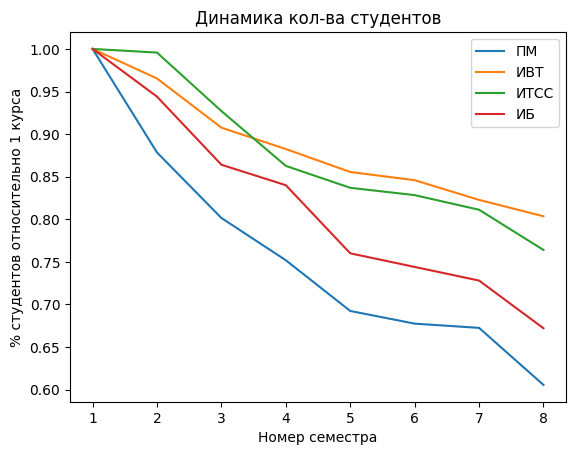

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

AM_1st = sm[sm['Program']=='ПМ'].at[3*8, 'Mean'] #получаем число студентов на первом курсе
IVT_1st = sm[sm['Program']=='ИВТ'].at[1*8, 'Mean']
ITSS_1st = sm[sm['Program']=='ИТСС'].at[2*8, 'Mean']
IB_1st = sm[sm['Program']=='ИБ'].at[0, 'Mean']

plt.plot(np.arange(1,9), sm[sm['Program']=='ПМ']['Mean']/AM_1st, label = 'ПМ') #нормируем
plt.plot(np.arange(1,9), sm[sm['Program']=='ИВТ']['Mean']/IVT_1st, label = 'ИВТ')
plt.plot(np.arange(1,9), sm[sm['Program']=='ИТСС']['Mean']/ITSS_1st, label = 'ИТСС')
plt.plot(np.arange(1,9), sm[sm['Program']=='ИБ']['Mean']/IB_1st, label = 'ИБ')

plt.xlabel("Номер семестра")
plt.ylabel("% студентов относительно 1 курса")
plt.title('Динамика кол-ва студентов')
plt.legend()

plt.show()

Получаем, что к последней сессии 4 курса на ПМ остается меньше всего студентов - около 60%, а на ИВТ больше всего - 80% :

In [ ]:
print('ПМ', sm[sm['Program']=='ПМ'].at[3*8+7, 'Mean'] / sm[sm['Program']=='ПМ'].at[3*8, 'Mean']*100)
print('ИВТ', sm[sm['Program']=='ИВТ'].at[1*8+7, 'Mean'] / sm[sm['Program']=='ИВТ'].at[1*8, 'Mean']*100)
print('ИТСС', sm[sm['Program']=='ИТСС'].at[2*8+7, 'Mean'] / sm[sm['Program']=='ИТСС'].at[2*8, 'Mean']*100)
print('ИБ', sm[sm['Program']=='ИБ'].at[7, 'Mean'] / sm[sm['Program']=='ИБ'].at[0, 'Mean']*100)

ПМ 60.54590570719603
ИВТ 80.34682080924856
ИТСС 76.39484978540773
ИБ 67.2


### Динамика среднего балла на каждом направлении

Посчитаем средний балл на каждой образовательной программе в каждом семестре:

In [ ]:
mgps = df.groupby(['Program', 'Course', 'Semester']).agg({'Average Grade': 'mean'}).reset_index() #mean_grade_per_semester

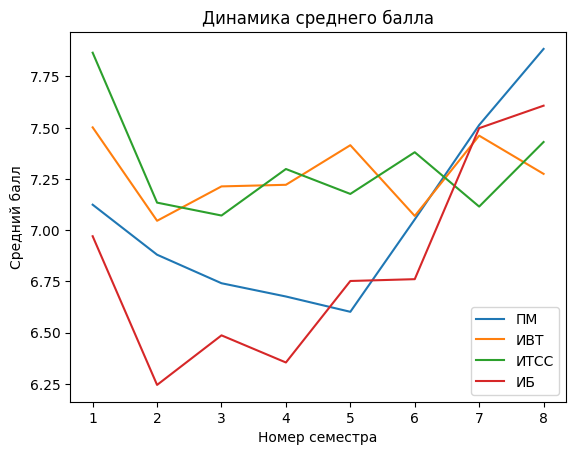

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(1,9), mgps[mgps['Program']=='ПМ']['Average Grade'], label = 'ПМ')
plt.plot(np.arange(1,9), mgps[mgps['Program']=='ИВТ']['Average Grade'], label = 'ИВТ')
plt.plot(np.arange(1,9), mgps[mgps['Program']=='ИТСС']['Average Grade'], label = 'ИТСС')
plt.plot(np.arange(1,9), mgps[mgps['Program']=='ИБ']['Average Grade'], label = 'ИБ')

plt.xlabel("Номер семестра")
plt.ylabel("Средний балл")
plt.title('Динамика среднего балла')
plt.legend()

plt.show()

Получаем неожиданный результат: на ОП ПМ и ИБ средний балл увеличивается после 5 семестра и под конец обучения даже становится выше, чем в самом начале. Это можно объяснить тем, что:
1. к 5 семестру отсеялись слабые студенты;
2. после середины обучения предметы стали более простыми.

Убедимся в том, что на ПМ и ИБ число студентов уменьшилось сильнее по сравнению с ИВТ и ИТСС. Воспользуемся кодом из предыдущего раздела:

In [ ]:
print('ПМ', sm[sm['Program']=='ПМ'].at[3*8+4, 'Mean'] / sm[sm['Program']=='ПМ'].at[3*8, 'Mean']*100)
print('ИВТ', sm[sm['Program']=='ИВТ'].at[1*8+4, 'Mean'] / sm[sm['Program']=='ИВТ'].at[1*8, 'Mean']*100)
print('ИТСС', sm[sm['Program']=='ИТСС'].at[2*8+4, 'Mean'] / sm[sm['Program']=='ИТСС'].at[2*8, 'Mean']*100)
print('ИБ', sm[sm['Program']=='ИБ'].at[4, 'Mean'] / sm[sm['Program']=='ИБ'].at[0, 'Mean']*100)

ПМ 69.23076923076923
ИВТ 85.54913294797689
ИТСС 83.69098712446352
ИБ 76.0


Получаем разницу, но незначительную. То есть это не основной фактор, который повлиял на рост среднего балла.

Также из графика видим, что в 1 семестре на всех ОП средний балл значительно выше, чем в нескольких последующих семестрах. Это связано с тем, что во 2 семестре происходит выбор дополнительных курсов, который основан на позиции студента в рейтинге, что мотивирует учиться студентов лучше.

На ИВТ и ИТСС видим, что средний балл после 1 семестра почти не имеет тендеций на рост или падение. Что можно связать с неизменчивым уровнем сложности предметов на ОП.

### Изменение успеваемости студентов

В этом разделе мы посмотрим, как изменялась успеваемость студентов с каждым новым набором студентов(потоком). Для каждого потока посчитаем средний балл на каждой сессии:

In [ ]:
flows = df.groupby(['Flow', 'Course', 'Semester']).agg({'Average Grade': 'mean'}).reset_index()
diff = flows.copy(deep=True)

Далее узнаем, насколько изменился их средний балл(посчитаем разницу) по сравнению с предыдущим потоком на этой сессии. Если значение для предыдущего потока неизвестно, то ставим 0:

In [ ]:
for flow in range(1,10+1):
  for course in range(1,4+1):
    for semester in range(1,2+1):
      mask = (diff['Course'] == course) & (diff['Semester'] == semester)

      #проверяем, есть ли определенный рейтинг у потока, а также, есть ли рейтинг предыдущего потока
      if (not diff[(diff['Flow'] == flow) & mask].empty) and (not diff[(diff['Flow'] == flow-1) & mask].empty):
        diff.loc[(diff['Flow'] == flow) & mask, 'Average Grade'] -= flows.loc[(flows['Flow'] == flow-1) & mask, 'Average Grade'].values[0]
      else:
        diff.loc[(diff['Flow'] == flow) & mask, 'Average Grade'] = 0

Для каждого потока считаем средную разницу(то есть узнаем, насколько средний балл за все сессии изменился по сравнению с предыдущим потоком):

In [ ]:
mean_diff = diff.groupby('Flow').agg({'Average Grade': 'mean'})

Используем кумулятивную сумму, чтобы нагляднее был виден тренд изменения успеваемости, и строим график:

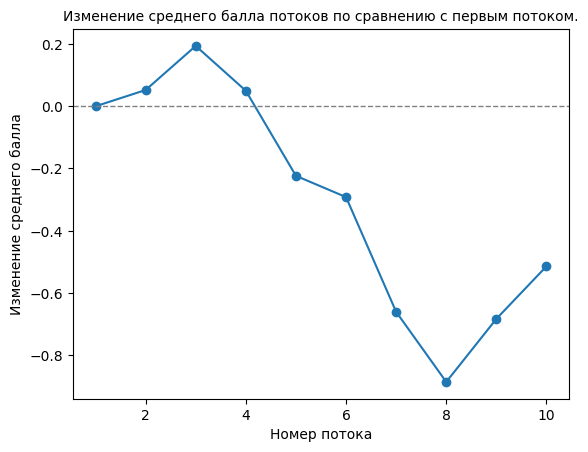

In [ ]:
import matplotlib.pyplot as plt

plt.plot(mean_diff.cumsum(), 'o-')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

plt.xlabel("Номер потока")
plt.ylabel("Изменение среднего балла")
plt.title('Изменение среднего балла потоков по сравнению с первым потоком.', size = 10)

plt.show()

Из графика видно, что успеваемость падала с 4 по 8 поток и все еще находится ниже, чем у 1-3 потоков. Это можно связать с увеличением кол-ва студентов при наборе на 1 курсе и соответственно набором более слабых студентов. А также с периодом удаленного обучения 2020-2022 гг.

Давайте посмотрим, как изменялось кол-во студентов принятых на первый курс:

In [ ]:
count = df[(df['Course'] == 1) & (df['Semester'] == 1)].groupby(['Program','Flow']).agg({'Student ID': 'count'}).reset_index()

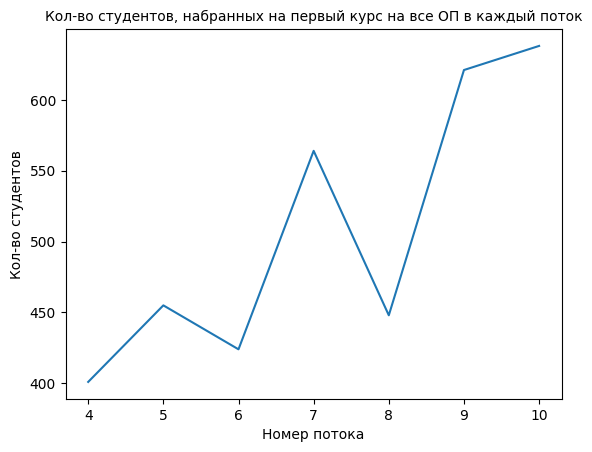

In [ ]:
plt.plot(count.groupby('Flow').agg({'Student ID':'sum'}))

plt.xlabel("Номер потока")
plt.ylabel("Кол-во студентов")
plt.title('Кол-во студентов, набранных на первый курс на все ОП в каждый поток', size = 10)

plt.show()

Видим, что кол-во студентов не влияет на успеваемость потока: на 8 поток было набрано меньше студентов, чем на 7, при этом он все еще учится хуже; в добавок на 9 и 10 потоки набрали рекордное кол-во студентов, а учатся они лучше, чем  8.

### Динамика переводов между бакалавриатами МИЭМ

Сначала найдем студентов, которые переводились внутри МИЭМ(то есть учились хотя бы на двух направлениях):

In [ ]:
students = df.groupby('Student ID').agg({'Program': 'nunique', 'Study year': 'count'})
students = students[(students['Program']>=2) & (students['Study year']<16)].reset_index()['Student ID']#оставляем людей с двумя программами и из них убираем с двумя бакалаврами

Находим откуда и куда переводился каждый студент:

In [ ]:
transf = df[df['Student ID'].isin(students)]
studs = []
direction = []

for stud in transf['Student ID'].unique():
  studs.append(stud)
  direction.append('->'.join(transf[transf['Student ID'] == stud].sort_values('Study year', ascending = True)['Program'].unique()))

res_trandf = pd.DataFrame({'Student ID': studs, 'Transfer': direction})

И получаем график с кол-вом переводов:

<Axes: title={'center': 'Переводы внутри МИЭМ'}, xlabel='Transfer', ylabel='Кол-во переводов'>

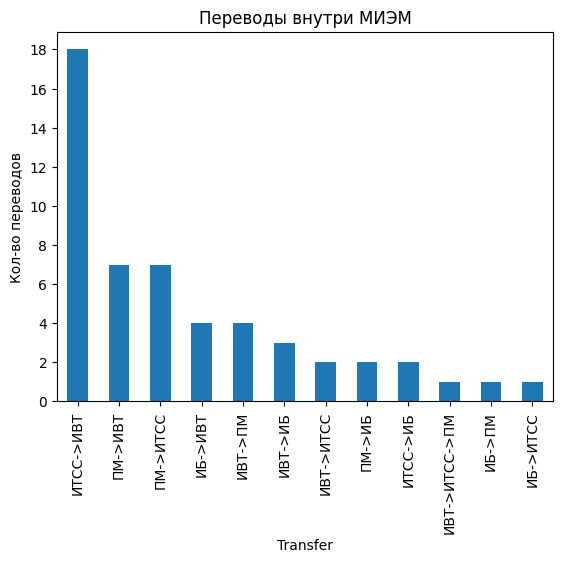

In [ ]:
import numpy as np
res_trandf['Transfer'].value_counts().plot(kind='bar', ylabel='Кол-во переводов', title = 'Переводы внутри МИЭМ', yticks = np.arange(0, 19, 2))

Видим, что чаще всего переводятся с ИТСС на ИВТ, с ПМ на ИТСС и ИВТ.
Теперь узнаем, куда и откуда чаще всего переводятся:

In [ ]:
res_trandf['From'] = None
res_trandf['To'] = None

for i in range(len(res_trandf['Transfer'])):
  s = res_trandf.loc[i, 'Transfer'].split('->')
  res_trandf.loc[i,'From'] = s[0]
  res_trandf.loc[i, 'To'] = s[-1]

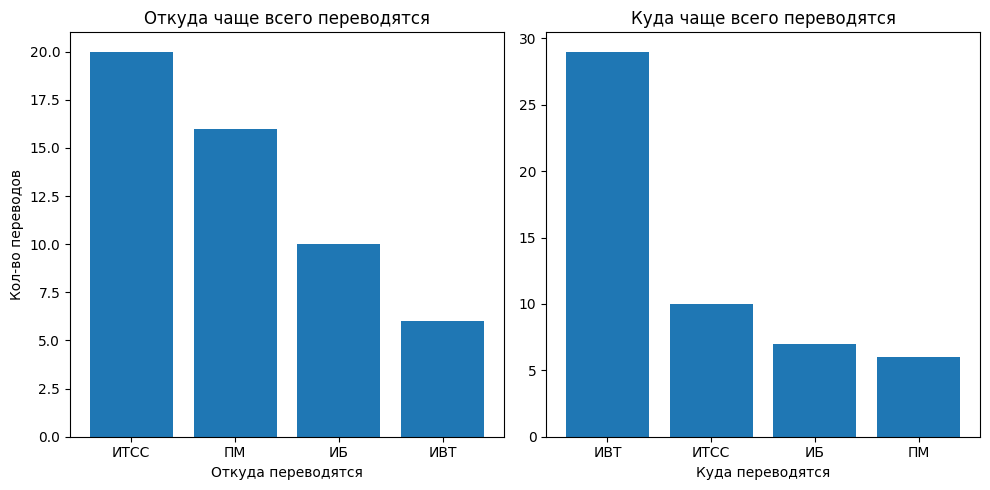

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize = (10, 5))

axes[0].bar(res_trandf['From'].unique(), res_trandf['From'].value_counts())
axes[1].bar(res_trandf['To'].unique(), res_trandf['To'].value_counts())

axes[0].set_title('Откуда чаще всего переводятся')
axes[1].set_title('Куда чаще всего переводятся')

axes[0].set_ylabel('Кол-во переводов')
axes[0].set_xlabel('Откуда переводятся')
axes[1].set_xlabel('Куда переводятся')

plt.tight_layout()

С ИТСС и ПМ чаще всего уходят студенты, а на ИВТ чаще всего переводятся, причем значительно чаще.

### Какой процент топ рейтинга оставался в нем навсегда

Возьмем студентов с перцентилем небольшим 20 и посчитаем, сколько раз встречался каждый студент:

In [ ]:
top_10 = df[(df['Flow'].isin([4,5,6])) & (df['Percentile']<=20)]
top_10_grouped = top_10.groupby(['Program', 'Flow', 'Student ID']).agg({'GPA': 'count'})

Найдем количество студентов на каждом направлении, которые встречались в топ 20 все 8 раз:

In [ ]:
k_students = top_10_grouped[top_10_grouped['GPA'] == 8].groupby(['Program']).agg({'GPA': 'count'})
k_students

,GPA
Program,
ИБ,3
ИВТ,21
ИТСС,7
ПМ,3


Теперь узнаем, сколько студентов было в топ 20 на первом курсе каждого направления(среди 4, 5 и 6 потоков):

In [ ]:
total_students = df[(df['Semester'] == 1) & (df['Course'] == 1) & (df['Flow'].isin([4,5,6]))].groupby(['Program']).agg({'Student ID': 'count'}) * 0.2

И посчитаем процент:

In [ ]:
students_share = pd.merge(k_students, total_students, on = ['Program'])
students_share.columns = ['Tops forever', 'Number in 1st']
students_share['Share, %'] =  round(students_share['Tops forever'] / students_share['Number in 1st'] * 100, 2)
students_share

,Tops forever,Number in 1st,"Share, %"
Program,,,
ИБ,3,25.0,12.00
ИВТ,21,103.8,20.23
ИТСС,7,46.6,15.02
ПМ,3,80.6,3.72


Получаем, что на ИВТ в 20% случаев студенты оставались в топ 20 рейтинга до конца обучения. А на ПМ таких было лишь 3%.

### Зависит ли доля студентов с пересдачей от образовательной программы

Для начала посчитаем долю пересдач на каждой сессии каждого направления(студент получил пересдачу, если у него оценка ниже 4):

In [4]:
def share_of_retakes(col):
  return len(col[col<4])/len(col)

retakes = df.groupby(['Program', 'Flow', 'Course', 'Semester']).agg({'Minimal Grade': share_of_retakes}).reset_index()

Делим полученный датафрейм на 4 части по образовательным программам - получаем 4 распределения.
Нам необходимо провести статистический тест, чтобы ответить на поставленный вопрос. Для этого посмотрим, распределены ли нормально 4 найденных распределения. Проверим это с помощью теста Шапиро-Уилка:

In [13]:
from scipy.stats import shapiro

retakes_share_for_programm = [
    retakes[retakes['Program'] == 'ПМ']['Minimal Grade'],
    retakes[retakes['Program'] == 'ИВТ']['Minimal Grade'],
    retakes[retakes['Program'] == 'ИБ']['Minimal Grade'],
    retakes[retakes['Program'] == 'ИТСС']['Minimal Grade']
]

for program in retakes_share_for_programm:
  print(shapiro(program))

ShapiroResult(statistic=np.float64(0.9312416689988877), pvalue=np.float64(0.0055563541678374274))
ShapiroResult(statistic=np.float64(0.947975203333166), pvalue=np.float64(0.025965961757815424))
ShapiroResult(statistic=np.float64(0.9228323904670866), pvalue=np.float64(0.02483094718280739))
ShapiroResult(statistic=np.float64(0.899065775866548), pvalue=np.float64(0.00039148553865754935))


Везде pvalue меньше 0.05, значит данные не распределены нормально.
В таком случае мы можем использовать непараметрический тест для нескольких выборок, а именно Критерий Краскела-Уоллиса:

In [14]:
from scipy.stats import kruskal

print( kruskal(retakes_share_for_programm[0], retakes_share_for_programm[1], retakes_share_for_programm[2], retakes_share_for_programm[3]).pvalue )

1.9006787720948343e-05


Видим, что pvalue значительно меньше 0.05, значит исходные распределения существенно отличаются друг от друга. То есть доля студентов с пересдачей зависит от образовательной программы